In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load training and testing data
train_data = pd.read_csv('/content/UNSW_NB15_training-set.csv')
test_data = pd.read_csv('/content/UNSW_NB15_testing-set.csv')


In [ ]:
# Separate features and labels
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']
X_test = test_data.drop('label', axis=1)
y_test = test_data['label']


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# Identify categorical columns in your data
categorical_cols = ['proto', 'service', 'state', 'attack_cat']  # Adjust based on actual categorical columns

# Encode categorical columns in both train and test sets
for col in categorical_cols:
    le = LabelEncoder()

    # Fit on the training data and transform both training and test data
    X_train[col] = le.fit_transform(X_train[col])

    # For test data, map labels that were not seen during training to a default value (-1)
    X_test[col] = X_test[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

# Now that all data is numeric, we can proceed with standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Use only normal (non-malicious) data to train the autoencoder
X_train_normal = X_train_scaled[y_train == 0]

In [ ]:
# Build the autoencoder model
input_dim = X_train_normal.shape[1]
encoding_dim = 14  # Adjust based on your data

In [ ]:
# Encoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
encoder = Dense(7, activation='relu')(encoder)

In [ ]:
# Decoder
decoder = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)

In [ ]:
# Autoencoder Model
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')


In [ ]:
# Train the Autoencoder
history = autoencoder.fit(X_train_normal, X_train_normal,
                          epochs=10,
                          batch_size=32,
                          validation_split=0.2)


Epoch 1/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.9125 - val_loss: 0.8602
Epoch 2/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6683 - val_loss: 0.8453
Epoch 3/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6522 - val_loss: 0.8441
Epoch 4/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6573 - val_loss: 0.8402
Epoch 5/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6389 - val_loss: 0.8394
Epoch 6/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6397 - val_loss: 0.8336
Epoch 7/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6548 - val_loss: 0.8330
Epoch 8/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6233 - val_loss: 0.8325
Epoch 9/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6593 - val_loss: 0.8320
Epoch 10/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6410 - val_loss: 0.8318


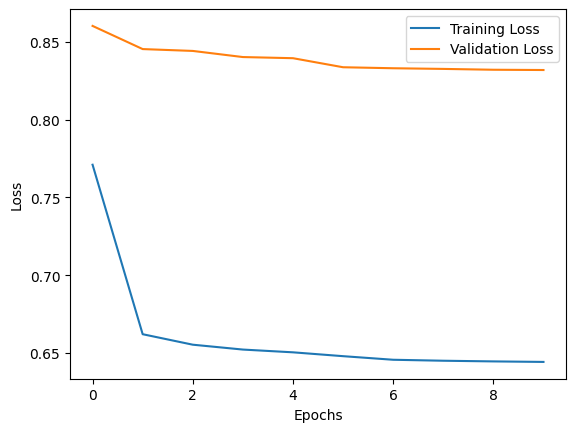

In [ ]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Reconstruction error on training set to determine threshold
X_train_predictions = autoencoder.predict(X_train)
train_reconstruction_errors = np.mean(np.square(X_train - X_train_predictions), axis=1)


2573/2573 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [ ]:
# Set the threshold for anomaly detection based on training reconstruction error
threshold = np.percentile(train_reconstruction_errors, 95)  # 95th percentile as an example


In [ ]:
# Calculate reconstruction error on test set
X_test_predictions = autoencoder.predict(X_test)
test_reconstruction_errors = np.mean(np.square(X_test - X_test_predictions), axis=1)

# Use threshold to classify anomalies
y_pred = (test_reconstruction_errors > threshold).astype(int)


5480/5480 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


In [ ]:
# Calculate accuracy
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)



Accuracy: 0.319725563330881


In [ ]:
# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.93      0.47     56000
           1       0.50      0.03      0.06    119341

    accuracy                           0.32    175341
   macro avg       0.41      0.48      0.26    175341
weighted avg       0.44      0.32      0.19    175341



In [ ]:
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[ 52014   3986]
 [115294   4047]]


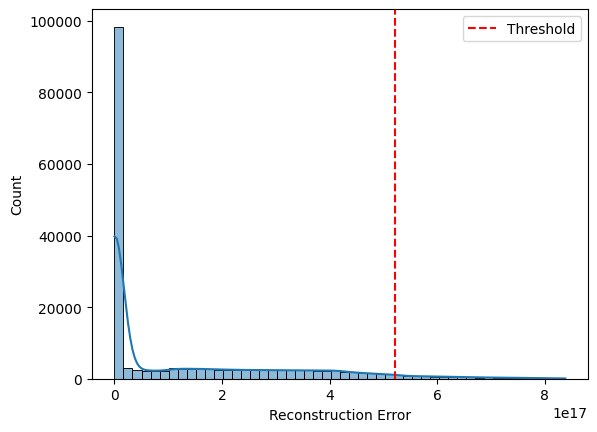

In [ ]:
# Visualize reconstruction error distribution with threshold line
sns.histplot(test_reconstruction_errors, bins=50, kde=True)
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel("Reconstruction Error")
plt.legend()
plt.show()